# TESS bandpass and cloudy and cloud-free model atmosphere spectra

In this notebook we compare cloudy and cloud-free models to the TESS bandpass to make a figure for the TESS Science Conference and the paper.

The next step after that will be to integrate the cloudy and clear models to produce synthetic photometry scaling relations that could hypothetically inform the filling factor of clouds.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import astropy.units as u
import numpy as np
import specutils
from specutils import Spectrum1D
%config InlineBackend.figure_format = 'retina'

In [2]:
plt.rcParams['figure.facecolor'] = 'white'

### Read in the TESS bandpass

In [3]:
#! wget https://heasarc.gsfc.nasa.gov/docs/tess/data/tess-response-function-v2.0.csv
#! mv tess-response-function-v2.0.csv ../../data/TESS/
#! head ../../data/TESS/tess-response-function-v2.0.csv

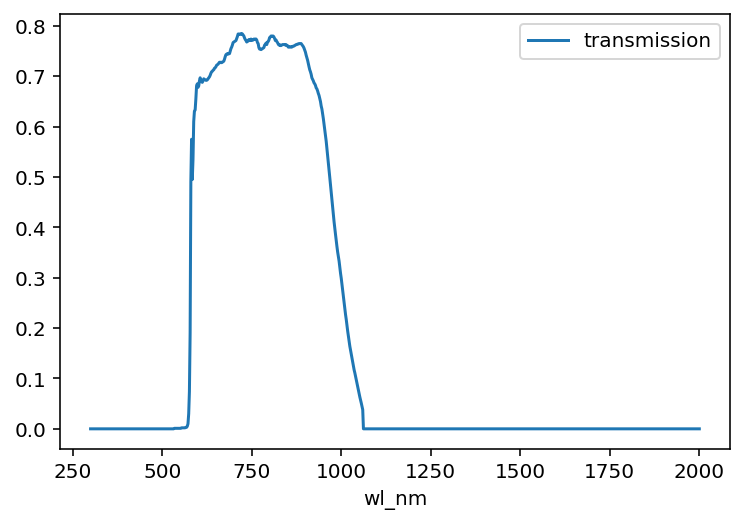

In [4]:
df_TESS = pd.read_csv('../../data/TESS/tess-response-function-v2.0.csv', 
                      skiprows=7, names=['wl_nm', 'transmission'])
df_TESS.plot('wl_nm', 'transmission');

In [5]:
tess_bandpass = Spectrum1D(spectral_axis=(df_TESS.wl_nm.values*u.nm).to(u.micron), 
                           flux=df_TESS.transmission.values*u.dimensionless_unscaled)

### Read in the models, convert to common units

The models use different units for flux.  We will convert them.

In [6]:
import os

In [130]:
fn = os.path.expanduser('~/libraries/raw/morley_clouds_20210322/ldwarf_specs/t1300g178f2_m0.0_co1.0.spec')

In [131]:
df_cloudy = pd.read_csv(fn, skiprows=[0,1], delim_whitespace=True, names=['wl_um','flux']
                      ).sort_values('wl_um').reset_index(drop=True)

In [155]:
df_cloud_free = pd.read_csv(os.path.expanduser('~/libraries/raw/marley/sp_t1500g178nc_m0.0'), 
                    skiprows=[0,1], delim_whitespace=True, names=['wl_um','flux']
                   ).sort_values('wl_um').reset_index(drop=True)

In [156]:
marley_unit = u.erg/u.cm**2/u.s/u.Hz
morley_unit = u.Watt/u.m**2/u.m

In [157]:
morley_flux_w_units = (df_cloudy.flux.values*morley_unit)
morley_wavelength = df_cloudy.wl_um.values*u.micron

morley_cgs = morley_flux_w_units.to(marley_unit, equivalencies=u.spectral_density(morley_wavelength))

In [158]:
cloudy_native = Spectrum1D(spectral_axis=df_cloudy.wl_um.values*u.micron, flux=morley_cgs)

In [159]:
cloud_free_native = Spectrum1D(spectral_axis=df_cloud_free.wl_um.values*u.micron, 
                               flux=df_cloud_free.flux.values*marley_unit)

### Resample the spectra to the TESS bandpass

In [160]:
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler

In [161]:
resampler = FluxConservingResampler(extrapolation_treatment='nan_fill')

In [162]:
%%capture
cloud_free = resampler(cloud_free_native, tess_bandpass.spectral_axis)
cloudy = resampler(cloudy_native, tess_bandpass.spectral_axis)

### Only keep the non-zero bandpass

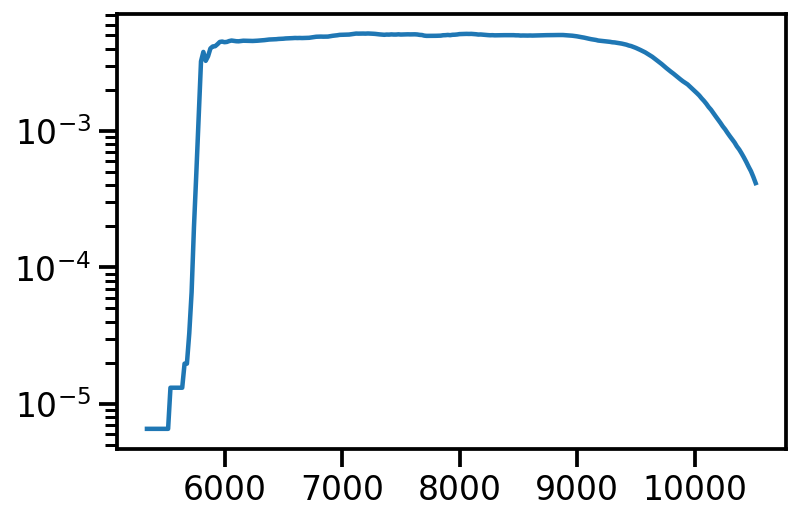

In [163]:
plt.plot(tess_bandpass.wavelength, tess_bandpass.flux)
plt.yscale('log')

In [164]:
mask = tess_bandpass.flux.value > 0

In [165]:
min_wl = tess_bandpass.wavelength[mask].value.min()*tess_bandpass.wavelength.unit
max_wl = tess_bandpass.wavelength[mask].value.max()*tess_bandpass.wavelength.unit

In [166]:
tess_bandpass = tess_bandpass[min_wl:max_wl]
cloudy = cloudy[min_wl:max_wl]
cloud_free = cloud_free[min_wl:max_wl]

Ok, our resampled spectrum should resemble the other.

In [167]:
import seaborn as sns

In [168]:
sns.set_context('talk')

In [169]:
marley_unit.to_string('latex')

'$\\mathrm{\\frac{erg}{Hz\\,s\\,cm^{2}}}$'

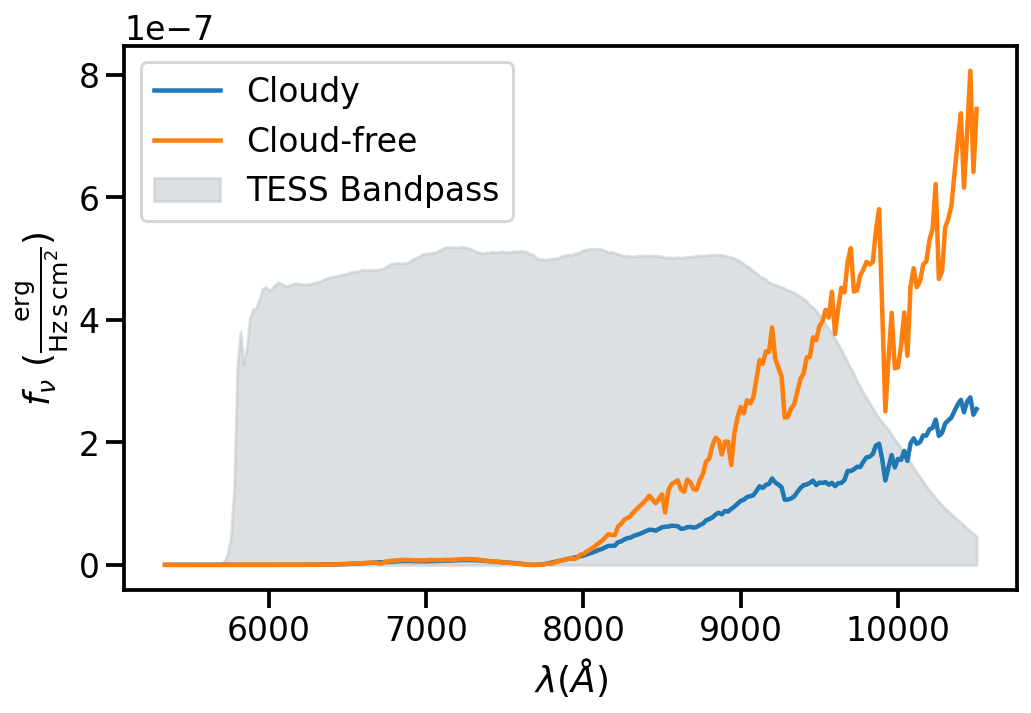

In [171]:
plt.figure(figsize=(8,5))
plt.plot(cloudy.wavelength, cloudy.flux, label='Cloudy');
plt.plot(cloud_free.wavelength, cloud_free.flux, label='Cloud-free');
plt.fill_between(tess_bandpass.wavelength, 
                 tess_bandpass.flux*np.median(cloudy.flux.value)*9_500, 
                 label='TESS Bandpass', color='#bdc3c7', alpha=0.5)
#plt.axvline(8340, linestyle='dashed', color='k', alpha=0.3)
#plt.axvline(10100, linestyle='dashed', color='k', alpha=0.3)
plt.legend(loc='best');
plt.xlabel('$\lambda (\AA)$')
plt.ylabel(r'$f_\nu$ ('+marley_unit.to_string('latex')+')');
plt.savefig('../../figures/TESS_bandpass_sonora_cloudy_brighter_holes.png', dpi=300, bbox_inches='tight')

### Weight by the TESS bandpass

In [86]:
scalar = cloudy.flux.mean()

tess_bandpass = tess_bandpass / tess_bandpass.flux.sum()

/Users/mag3842/miniforge3/envs/varsity_m1/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:2567: RuntimeWarning: invalid value encountered in true_divide
  norm_distances.append((x - grid[i]) /


In [87]:
cloudy_weighted = cloudy * tess_bandpass / scalar
cloud_free_weighted = cloud_free * tess_bandpass / scalar

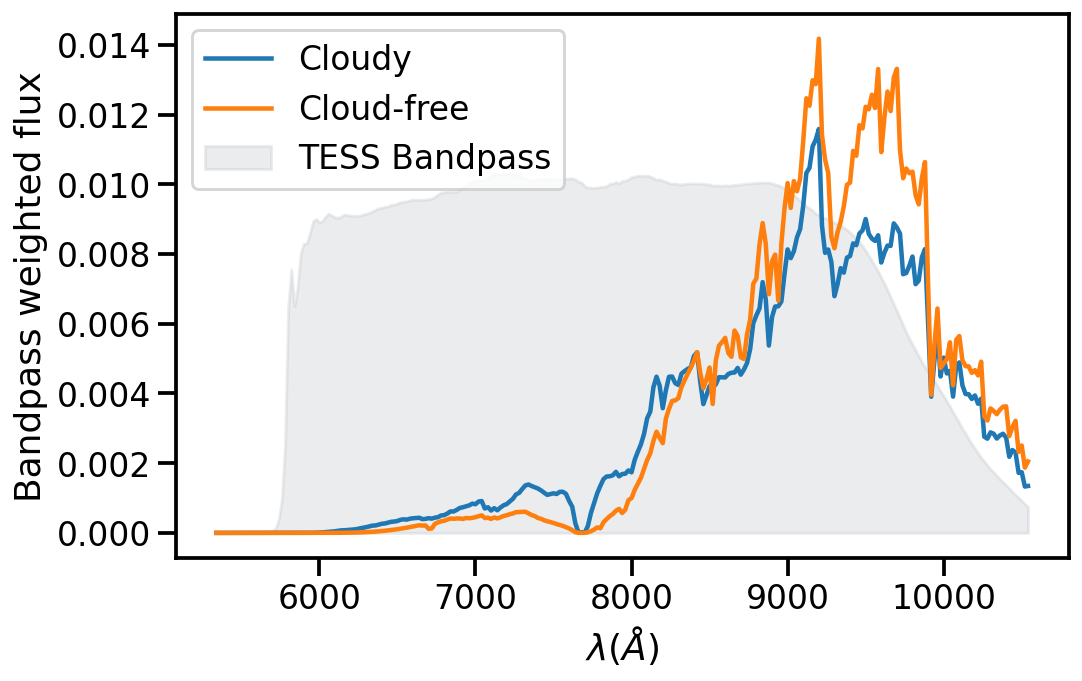

In [88]:
plt.figure(figsize=(8,5))
plt.plot(cloudy_weighted.wavelength, cloudy_weighted.flux, label='Cloudy');
plt.plot(cloud_free_weighted.wavelength, cloud_free_weighted.flux, label='Cloud-free');
plt.fill_between(tess_bandpass.wavelength, 
                 tess_bandpass.flux*2, 
                 label='TESS Bandpass', color='#bdc3c7', alpha=0.3)
plt.legend(loc='best');
plt.xlabel('$\lambda (\AA)$')
plt.ylabel('Bandpass weighted flux');

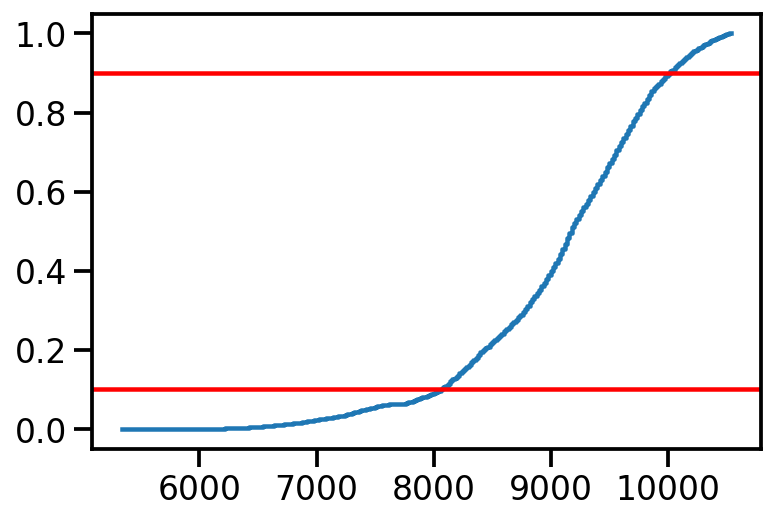

In [89]:
plt.step(cloudy_weighted.wavelength, 
         cloudy_weighted.flux.value.cumsum()/cloudy_weighted.flux.value.sum(), 
         label='Cloudy');
plt.axhline(0.10, color='r')
plt.axhline(0.90, color='r')

In [90]:
vec = cloudy_weighted.flux.value.cumsum()/cloudy_weighted.flux.value.sum()

In [91]:
cloudy_weighted.wavelength[vec > 0.1]

<SpectralAxis [ 8080.,  8100.,  8120.,  8140.,  8160.,  8180.,  8200.,  8220.,  8240.,
    8260.,  8280.,  8300.,  8320.,  8340.,  8360.,  8380.,  8400.,  8420.,
    8440.,  8460.,  8480.,  8500.,  8520.,  8540.,  8560.,  8580.,  8600.,
    8620.,  8640.,  8660.,  8680.,  8700.,  8720.,  8740.,  8760.,  8780.,
    8800.,  8820.,  8840.,  8860.,  8880.,  8900.,  8920.,  8940.,  8960.,
    8980.,  9000.,  9020.,  9040.,  9060.,  9080.,  9100.,  9120.,  9140.,
    9160.,  9180.,  9200.,  9220.,  9240.,  9260.,  9280.,  9300.,  9320.,
    9340.,  9360.,  9380.,  9400.,  9420.,  9440.,  9460.,  9480.,  9500.,
    9520.,  9540.,  9560.,  9580.,  9600.,  9620.,  9640.,  9660.,  9680.,
    9700.,  9720.,  9740.,  9760.,  9780.,  9800.,  9820.,  9840.,  9860.,
    9880.,  9900.,  9920.,  9940.,  9960.,  9980., 10000., 10020., 10040.,
   10060., 10080., 10100., 10120., 10140., 10160., 10180., 10200., 10220.,
   10240., 10260., 10280., 10300., 10320., 10340., 10360., 10380., 10400.,
   10420., 10

In [92]:
cloudy_weighted.wavelength[vec > 0.9]

<SpectralAxis [10040., 10060., 10080., 10100., 10120., 10140., 10160., 10180., 10200.,
   10220., 10240., 10260., 10280., 10300., 10320., 10340., 10360., 10380.,
   10400., 10420., 10440., 10460., 10480., 10500., 10520., 10540.] Angstrom>

## Plot the band-integrated flux as a function of fill-factor

We use a mixture model for the net, band-integrated flux.

In [93]:
fill_factors = np.arange(0, 1.001, 0.02)

In [94]:
@np.vectorize
def mixture_model(ff):
    '''Compute the mixture model for an input filling factor of clouds, $f_{cloud}$'''
    net_spec = ff * cloudy_weighted.flux + (1-ff) * cloud_free_weighted.flux
    return net_spec.value.sum()

In [95]:
observed_fluxes = mixture_model(fill_factors)
observed_fluxes_norm = observed_fluxes / observed_fluxes.max()

In [96]:
#observed_fluxes_1000 = observed_fluxes_norm

In [97]:
#observed_fluxes_1300 = observed_fluxes_norm

In [98]:
#observed_fluxes_1600 = observed_fluxes_norm

In [35]:
min_flux = observed_fluxes_norm.min()

In [36]:
min_flux

0.8826833320076317

In [120]:
(observed_fluxes_1300[1:]-observed_fluxes_1300[0:-1])/ 0.02 * 0.01

array([-0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571,
       -0.00166571, -0.00166571, -0.00166571, -0.00166571, -0.00166571])

## Result: A 1% change in filling factor results in a TESS-band flux loss of 0.16%.

In order to achieve a 10% change in flux, the spot coverage had to change by:

In [123]:
10/0.16

62.5

62.5%

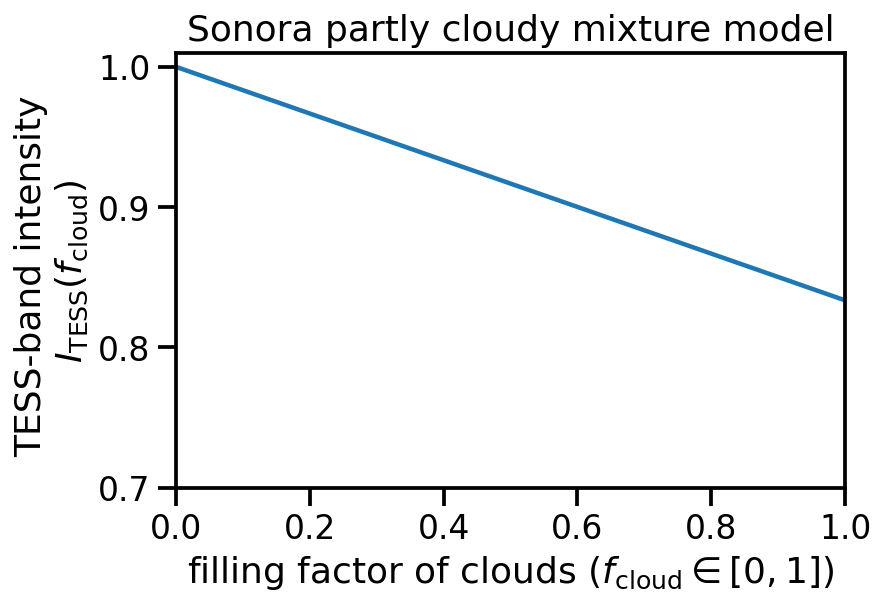

In [129]:
plt.plot(fill_factors, observed_fluxes_1300, label='1300 K ');
plt.xlabel('filling factor of clouds $(f_{\mathrm{cloud}}\in [0, 1])$');
plt.ylabel('TESS-band intensity \n$I_{\mathrm{TESS}}(f_{\mathrm{cloud}})$')
plt.ylim(0.7, 1.01)
plt.xlim(0,1)
#plt.axhline(min_flux, color='k', alpha=0.3, linestyle='dashed')
plt.title('Sonora partly cloudy mixture model')
#plt.legend(title='$T_{\mathrm{eff}}$', fontsize=13, ncol=3);
plt.savefig('../../figures/sonora_mixture_model_scaling1300.png', dpi=300, bbox_inches='tight')

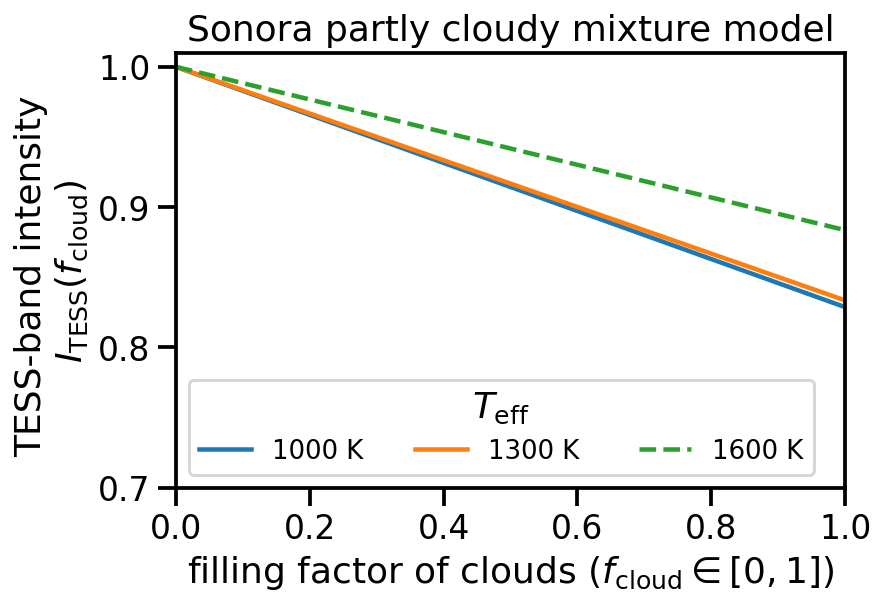

In [124]:
plt.plot(fill_factors, observed_fluxes_1000, label='1000 K');
plt.plot(fill_factors, observed_fluxes_1300, label='1300 K ');
plt.plot(fill_factors, observed_fluxes_1600, label='1600 K', linestyle='dashed');
plt.xlabel('filling factor of clouds $(f_{\mathrm{cloud}}\in [0, 1])$');
plt.ylabel('TESS-band intensity \n$I_{\mathrm{TESS}}(f_{\mathrm{cloud}})$')
plt.ylim(0.7, 1.01)
plt.xlim(0,1)
#plt.axhline(min_flux, color='k', alpha=0.3, linestyle='dashed')
plt.title('Sonora partly cloudy mixture model')
plt.legend(title='$T_{\mathrm{eff}}$', fontsize=13, ncol=3);
plt.savefig('../../figures/sonora_mixture_model_scaling.png', dpi=300, bbox_inches='tight')

In [125]:
! open ../../figures/

In [127]:
1-observed_fluxes_1300.min()

0.16657131813237658